In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.decomposition import PCA
import kmapper as km
import ripser
import numpy as np
import matplotlib.pyplot as plt 
import time
import os

In [0]:
print (tf.__version__)

2.2.0-rc3


In [0]:
#Load data - prepare training data and normalize images to -1, 1
(train_images, train_labels), (temp_images, temp_labels) = mnist.load_data()
Train_images = np.append(train_images, temp_images, axis=0)
Train_labels = np.append(train_labels, temp_labels, axis=0)
Train_images = Train_images.reshape(Train_images.shape[0], 28, 28, 1).astype('float32')
Train_images = (Train_images - 127.5) / 127.5
Buffer_Size = 700000
Batch_Size = 256
Train_Data_Set = tf.data.Dataset.from_tensor_slices(Train_images).shuffle(Buffer_Size).batch(Batch_Size)


In [0]:



def Build_Generator_Model():
    '''
    Generator model:
    Input: random seed
    Upsamples to produce an image 
    Output: 28x28x1 image
    '''
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model 

def Build_Discriminator_Model():
    '''
    ConvNet Image Classifier
    '''
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model 


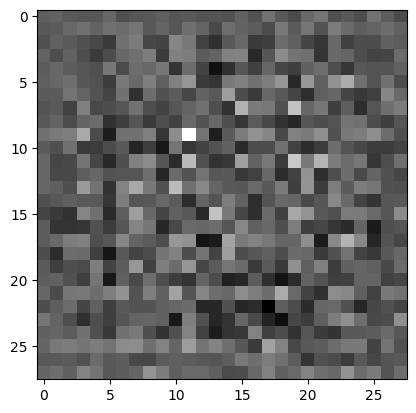

In [0]:
Generator = Build_Generator_Model()
noise = tf.random.normal([1, 100])
generated_image_test = Generator(noise, training=False)
plt.imshow(generated_image_test[0,:,:,0], cmap='gray')

In [0]:
Discriminator = Build_Discriminator_Model()
Decision_Test = Discriminator(generated_image_test)
print(Decision_Test)

tf.Tensor([[-0.00214648]], shape=(1, 1), dtype=float32)


In [0]:
Generator_Optimizer = Adam(1e-4)
Discriminator_Optimizer = Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(Generator_Optimizer=Generator_Optimizer, Discriminator_Optimizer=Discriminator_Optimizer, Generator=Generator, Discriminator=Discriminator)

In [0]:


cross_entropy = BinaryCrossentropy(from_logits=True)

def Generator_Loss(fake_output):
    '''
    Define loss function for Generator Model 
    Discriminator output for each image is compared to an array of 1's 
    '''
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def Discriminator_Loss(real_output, fake_output):
    '''
    Defines loss function for Discriminator Model
    1 is assigned to Real Images
    0 is assigned to Fake Images
    Output: Sum Total Loss
    '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss




EPOCHS = 30
NOISE_DIM = 100
Num_Images_to_Generate = 6
seed = tf.random.normal([Num_Images_to_Generate, NOISE_DIM])

@tf.function
def Train_Step(images):
    noise = tf.random.normal([Batch_Size, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        Generated_Images = Generator(noise, training=True)
        real_output = Discriminator(images, training=True)
        fake_output = Discriminator(Generated_Images, training=True)
        Gen_Loss = Generator_Loss(fake_output)
        Disc_Loss = Discriminator_Loss(real_output, fake_output)

    Generator_Grads = gen_tape.gradient(Gen_Loss, Generator.trainable_variables)
    Discriminator_Grads = disc_tape.gradient(Disc_Loss, Discriminator.trainable_variables)
    Generator_Optimizer.apply_gradients(zip(Generator_Grads, Generator.trainable_variables))
    Discriminator_Optimizer.apply_gradients(zip(Discriminator_Grads, Discriminator.trainable_variables))


def Generate_and_Save_Images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, : , 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


def Train(Dataset, epochs):
    '''
    Train the DCGAN on a Dataset for a given number of epochs
    ''' 
    for epoch in range(epochs):
        start = time.time()

        for image_batch in Dataset:
            Train_Step(image_batch)
        
        Generate_and_Save_Images(Generator, epoch + 1, seed)
        if(epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)
        print(f'Time for Epoch: {epoch + 1} is {time.time() - start}')
    Generate_and_Save_Images(Generator, epochs, seed)





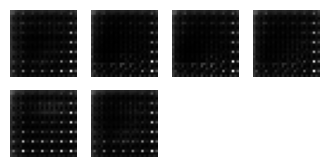

Time for Epoch: 1 is 16.433072090148926


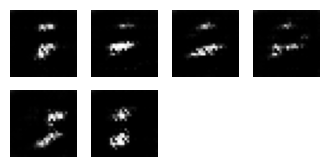

Time for Epoch: 2 is 14.569010257720947


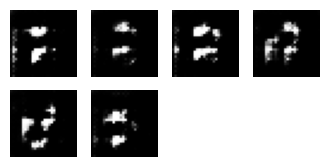

Time for Epoch: 3 is 14.575570344924927


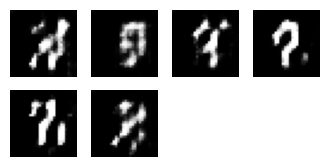

Time for Epoch: 4 is 14.573712348937988


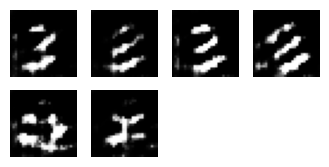

Time for Epoch: 5 is 14.57902717590332


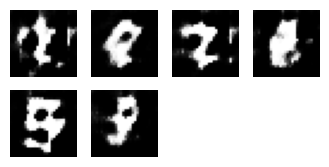

Time for Epoch: 6 is 14.57282280921936


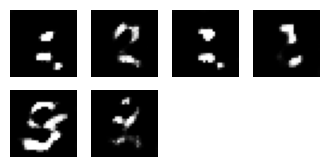

Time for Epoch: 7 is 14.73585295677185


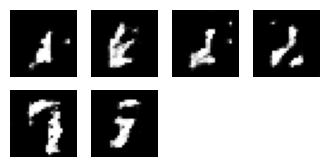

Time for Epoch: 8 is 14.590752124786377


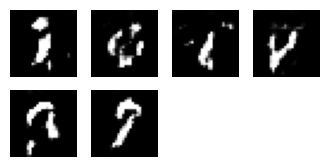

Time for Epoch: 9 is 14.622614860534668


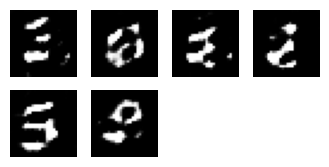

Time for Epoch: 10 is 14.625924825668335


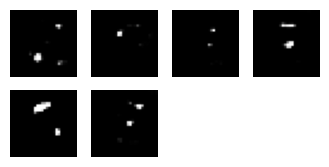

Time for Epoch: 11 is 14.598542213439941


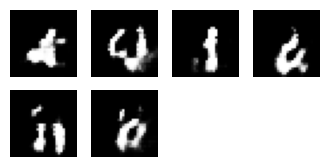

Time for Epoch: 12 is 14.598459482192993


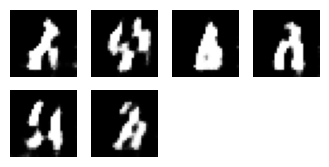

Time for Epoch: 13 is 14.617496490478516


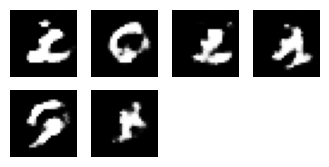

Time for Epoch: 14 is 14.672959566116333


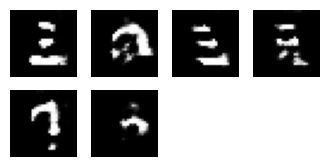

Time for Epoch: 15 is 14.723830938339233


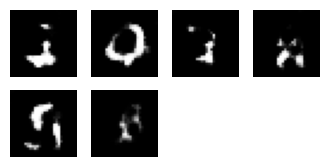

Time for Epoch: 16 is 14.58925199508667


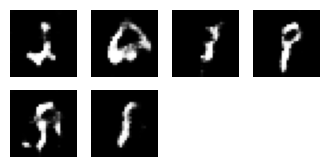

Time for Epoch: 17 is 14.847620964050293


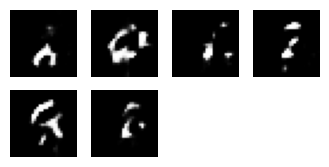

Time for Epoch: 18 is 14.633079051971436


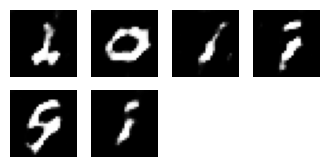

Time for Epoch: 19 is 14.639806985855103


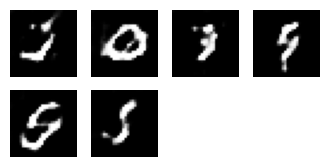

Time for Epoch: 20 is 14.597617149353027


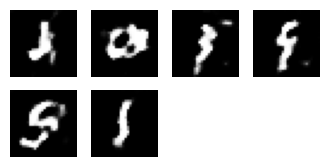

Time for Epoch: 21 is 14.605225801467896


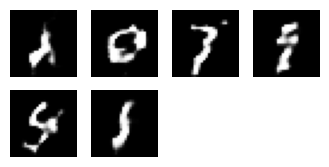

Time for Epoch: 22 is 14.636329174041748


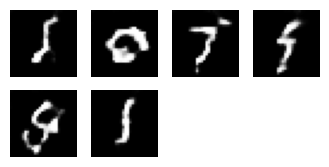

Time for Epoch: 23 is 14.61527943611145


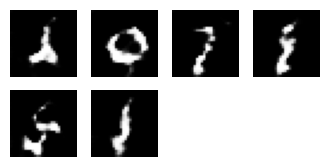

Time for Epoch: 24 is 14.614175081253052


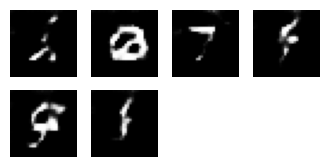

Time for Epoch: 25 is 14.637664794921875


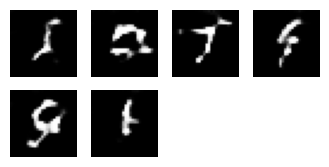

Time for Epoch: 26 is 14.605406284332275


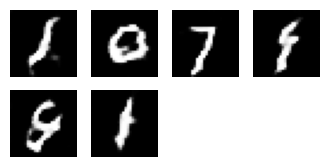

Time for Epoch: 27 is 14.568978071212769


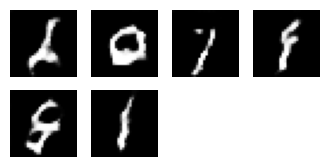

Time for Epoch: 28 is 14.80672574043274


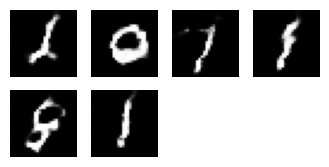

Time for Epoch: 29 is 14.62915849685669


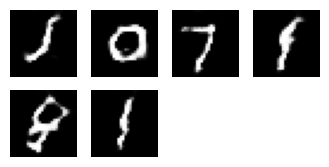

Time for Epoch: 30 is 14.663593053817749


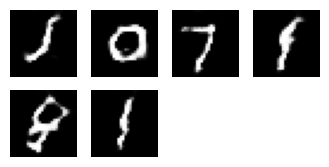

In [0]:
Train(Train_Data_Set, EPOCHS)

(1, 100)
<class 'tensorflow.python.framework.ops.EagerTensor'>


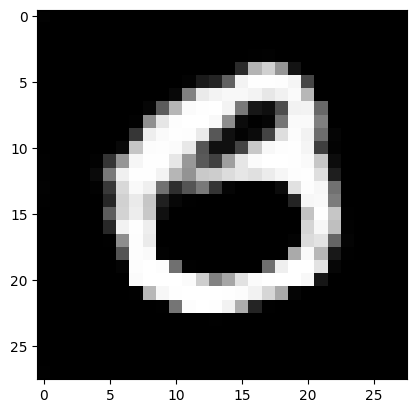

In [0]:
noise = tf.random.normal([1, 100])
generated_image_test = Generator(noise, training=False)
print(noise.shape)
print(type(generated_image_test))
plt.imshow(generated_image_test[0,:,:,0], cmap='gray')

In [0]:
Generator_Optimizer = SGD(learning_rate=0.01, momentum=0)
#Generator_Optimizer = Adam(1e-4)

def Generator_Topological_Loss(p, q, i_0, PD):
    '''
    Define topological loss
    input:
    p - ########
    q - ###########
    i_0 - ###########
    Pers_Hom - ###########
    Output: ###########
    Topological loss from Persistence Homology 
    '''
    top_Loss = 0

    for j in range(len(PD)):
      for i in range(i_0, len(PD[j])):
        #top_Loss += tf.__mul__(tf.__pow__(tf.__add__(Pers_Hom[j][i_0:][1], tf.__neg__(Pers_Hom[j][i_0:][0])), p), tf.__pow__(tf.__div__(tf.__add__(Pers_Hom[j][i_0:][1], Pers_Hom[j][i_0][0]), 2), q))
        if PD[j][i][1] == np.inf:
          PD[j][i][1] = 9
        top_Loss += (((PD[j][i][1] - PD[j][i][0])**p) * (((PD[j][i][1] + PD[j][i][0]) / 2)**q))
    return top_Loss
    #return top_Loss / len(Pers_Hom)


In [0]:
@tf.function
def Train_Top_Step(noise):
    Generated_Images = Generator(noise, training=True)
    rips = ripser.Rips()
    #PD = [tf.convert_to_tensor(rips.fit_transform(Generated_Images[i,:,:,0], metric='euclidean')) for i in range(Batch_Size)]
    TEST = list(Generated_Images[0,:,:,0])
    #PD = rips.fit_transform(Generated_Images[0,:,:,0], metric='euclidean')
    PD = rips.fit_transform(TEST, metric='euclidean')

    #PD = rips.fit_transform(TEST, metric='euclidean')

    Gen_Loss = Generator_Topological_Loss(1, 0, 2, PD)
    Generator_Grads = tf.GradientTape().gradient(Gen_Loss, Generator.trainable_variables)
    Generator_Optimizer.apply_gradients(zip(Generator_Grads, Generator.trainable_variables))

def Train_W_Top_Loss(Dataset, epochs):
    '''
    Continue training Generator with Topological Loss
    '''
    noise = tf.random.normal([1, NOISE_DIM])
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in Dataset:
            Train_Top_Step(noise)
        
        Generate_and_Save_Images(Generator, epoch + 1, seed)
        if(epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print(f'Time for Epoch: {epoch + 1} is {time.time() - start}')
    Generate_and_Save_Images(Generator, epochs, seed)

In [0]:
Train_W_Top_Loss(Train_Data_Set, EPOCHS) 

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


OperatorNotAllowedInGraphError: ignored

In [0]:
noise = tf.random.normal([Batch_Size, NOISE_DIM])
Generated_Images = Generator(noise, training=False)
rips = ripser.Rips()
#PD = [tf.convert_to_tensor(rips.fit_transform(Generated_Images[i,:,:,0], metric='euclidean')) for i in range(Batch_Size)]
PD = rips.fit_transform(Generated_Images[0,:,:,0], metric='euclidean')
Gen_Loss = Generator_Topological_Loss(1, 0, 2, PD)
print(Generated_Images.shape)
print('step')

#########################
'''
top_Loss_try = 0

for j in range(1):
  for i in range(2, len(PD[j])):
        #top_Loss += tf.__mul__(tf.__pow__(tf.__add__(Pers_Hom[j][i_0:][1], tf.__neg__(Pers_Hom[j][i_0:][0])), p), tf.__pow__(tf.__div__(tf.__add__(Pers_Hom[j][i_0:][1], Pers_Hom[j][i_0][0]), 2), q))
        if PD[j][i][1] == np.inf:
          PD[j][i][1] = 9
        #print(top_Loss_try)
        #print(i)
        top_Loss_try += (PD[j][i][1] - PD[j][i][0])**1
        
    #return top_Loss / len(Pers_Hom)
print(top_Loss_try)

print(PD)
'''
print(type(list(Generated_Images[0,:,:,0])))

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
(256, 28, 28, 1)
step
<class 'list'>


/usr/local/lib/python3.6/dist-packages/ripser/ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"


In [0]:
!pip install -q kmapper

     |████████████████████████████████| 102kB 9.2MB/s 


In [0]:
!pip install -q ripser

     |████████████████████████████████| 81kB 8.6MB/s 


In [0]:
import kmapper 
import ripser


In [0]:
generated_image_test = tf.keras.backend.reshape(generated_image_test, (generated_image_test.shape[0],28,28))

In [0]:
#generated_image_test
pca = PCA(n_components=3)
pca.fit(generated_image_test)
Projected_IMG = pca.transform(generated_image_test)
print(Projected_IMG)

[[-1.92234816  0.39912439 -0.54933929]
 [-1.92534381  0.40033432 -0.5495931 ]
 [-1.92571479  0.40073882 -0.54823773]
 [-2.03412953  0.52635041 -0.1164364 ]
 [-2.1138634   0.9192926   1.34371681]
 [-1.31151294  1.601842    2.52419857]
 [ 0.09840581  1.49590625  2.7028873 ]
 [ 1.40507441 -0.26406067  2.35053091]
 [ 1.76625727 -0.93485999  2.23742694]
 [ 2.04361755 -1.27292577  1.96823758]
 [ 2.36712555 -1.04668398  1.35979002]
 [ 1.94678973  0.66198112  0.00931712]
 [ 1.93475268  3.18690055 -1.3556872 ]
 [ 1.20356455  3.43004204 -1.04315037]
 [ 1.55603159  2.70073308 -0.89127856]
 [ 3.71590613  0.12330396 -1.81475999]
 [ 2.94212754 -1.53492615 -1.65206526]
 [ 1.34413958 -2.1088539  -0.80667046]
 [-0.69518136 -1.16853949 -0.26966336]
 [-0.66311793 -1.37032884 -0.3206691 ]
 [-0.75891511 -1.54403545 -0.47261559]
 [-0.92515    -1.46279744 -0.55805123]
 [-0.8664035  -1.51469833 -0.5798463 ]
 [-0.56459313 -1.70945026 -0.64185229]
 [-0.97116824 -0.94692151 -0.65692188]
 [-1.79702642  0.23208494

In [0]:
mapper = kmapper.KeplerMapper(verbose=1)

# Fit to and transform the data
projected_data = mapper.fit_transform(Projected_IMG, projection=[0,1]) # X-Y axis

# Create dictionary called 'graph' with nodes, edges and meta-information
graph = mapper.map(projected_data, Projected_IMG, nr_cubes=10)

# Visualize it
mapper.visualize(graph, path_html="make_circles_keplermapper_output.html",
                 title="Test")

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (28, 3)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler(copy=True, feature_range=(0, 1))

Mapping on data shaped (28, 3) using lens shaped (28, 2)

Creating 100 hypercubes.

Created 0 edges and 2 nodes in 0:00:00.006580.
Wrote visualization to: make_circles_keplermapper_output.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Test | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  position: absolute;\n  right: 00px;\n  top: 0px;\n  width: 90px;\n  height: 90px;\n  z-index: 999999;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-siz

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
<class 'list'>
[array([[0.00000000e+00, 3.28067399e-04],
       [0.00000000e+00, 5.49767050e-04],
       [0.00000000e+00, 2.11222353e-03],
       [0.00000000e+00, 4.35641967e-03],
       [0.00000000e+00, 1.40531054e-02],
       [0.00000000e+00, 1.02757432e-01],
       [0.00000000e+00, 1.11373745e-01],
       [0.00000000e+00, 2.00241029e-01],
       [0.00000000e+00, 2.58494407e-01],
       [0.00000000e+00, 2.83018976e-01],
       [0.00000000e+00, 4.53554392e-01],
       [0.00000000e+00, 6.90777898e-01],
       [0.00000000e+00, 8.96041811e-01],
       [0.00000000e+00, 9.98148084e-01],
       [0.00000000e+00, 1.04868364e+00],
       [0.00000000e+00, 1.22063792e+00],
       [8.42936956e-08, 1.25544107e+00],
       [0.00000000e+00, 1.47334385e+00],
       [0.00000000e+00, 1.50484240e+00],
       [0.00000000e+00, 1.50935233e+00],
       [0.00000000e+00, 1.55090821e+00],
       [0.00000000e+00, 1.64917326e+00]

/usr/local/lib/python3.6/dist-packages/ripser/ripser.py:216: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  + "this was a distance matrix?"


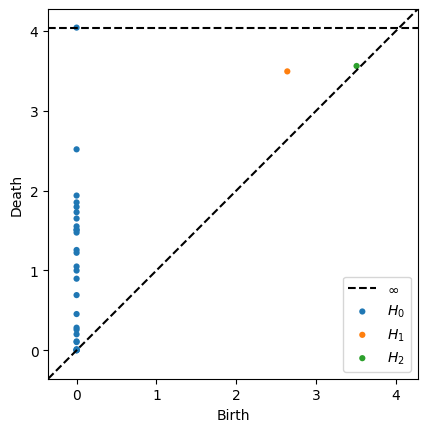

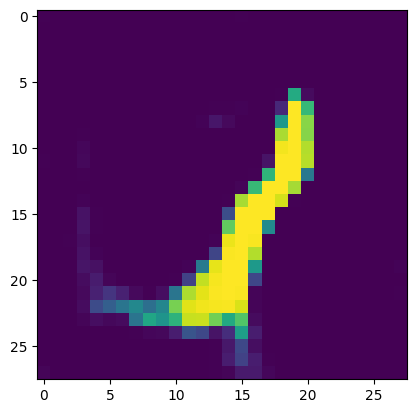

In [0]:
rips = ripser.Rips(maxdim=2)
diagms = rips.fit_transform(generated_image_test[0], metric='euclidean')
print(type(diagms))
print(diagms)
print(np.array(diagms).shape)
rips.plot(diagms)
plt.figure(num=2)
plt.imshow(generated_image_test[0])